# COURSE: A deep understanding of deep learning
## SECTION: Regularization
### LECTURE: Batch training in action
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import pandas as pd

C:\sofware\anaconda3\envs\projects\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = pd.read_csv('../../data/iris.csv')

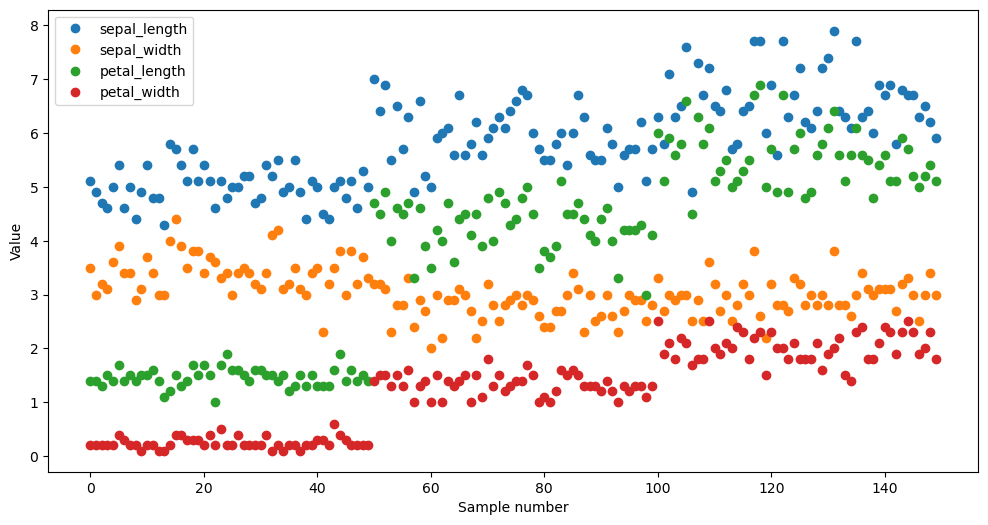

In [3]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

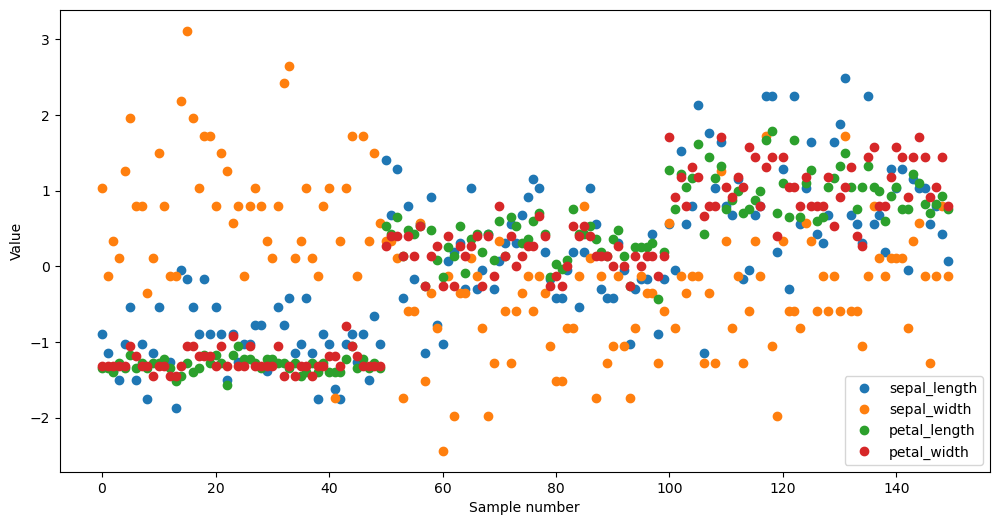

In [13]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
import scipy.stats as stats
cols2zscore = iris.keys()
cols2zscore = cols2zscore.drop('species')
iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [14]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa']   = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica']  = 2

# Break the data into batches

In [15]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??

In [16]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


# Construct the model and training plans

In [17]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [18]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)
      
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses


# Test it out

In [19]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()


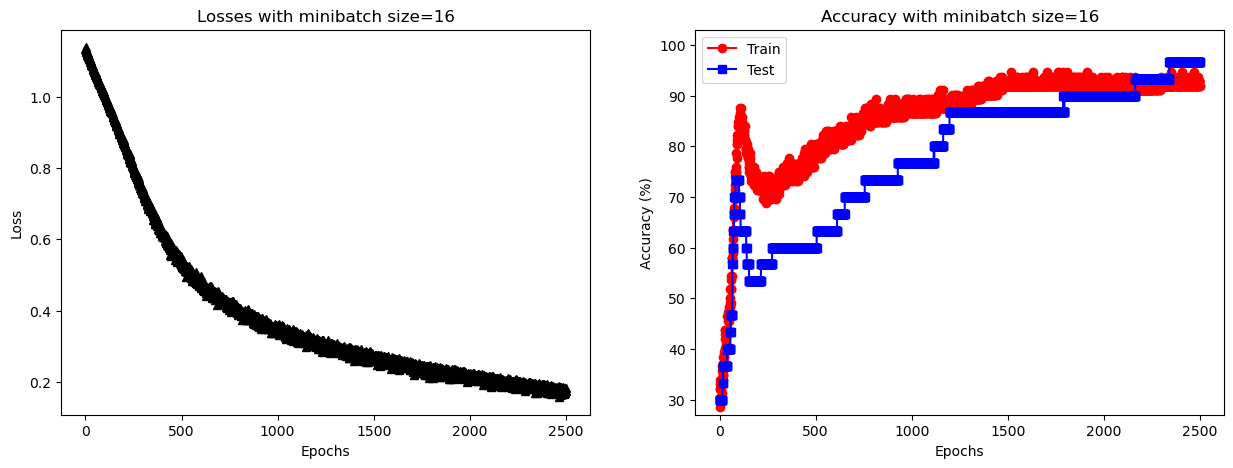

In [20]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Additional explorations

In [12]:
# 1) Is there a relationship between the test_size parameter in train_test_split(), the batchsize parameter in DataLoader,
#    and the length of test_data? Think of your answer first, then test it in code, by creating new dataloader objects 
#    with varying test_size parameters.
#    Hint: You can use the code 'len(test_data.dataset.tensors[1])', which returns the length of the labels vector.
# 
# 2) Let's say you didn't care about the three types of irises; you only want a model that labels a flower as setosa or 
#    "other." What would you have to change in the data and in the model to make this work?
# 
# 3) In the course section "More on data," you will learn that unbalanced designs can be problematic for DL models (an
#    unbalanced design means that there is an uneven distribution of samples in different categories). Does the 
#    modification in #2 produce an unbalanced design? To find out, count the number of data labels that are 0 (setosa) or
#    1 (not setosa).
# 